# CDD_CNN_Transformer_best

This notebook contains the consolidated, best-practice multimodal CNN + Transformer training pipeline adapted from existing CDD_CNN_Transformer notebooks. It includes robust image loading (handles missing views), TF-IDF text features, metadata encoding, optional RadImageNet encoder with a small CNN fallback, feature caching, training and evaluation.

The notebook is organized into sections for reproducible experiment tracking, data loading, preprocessing, modeling, evaluation and saving artifacts.

In [44]:
# Full pipeline: imports, config, helpers, model, training

# Section 1: imports and configuration
import os
import json
import sys
import platform
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D, GlobalAveragePooling1D,
                                     TimeDistributed, Concatenate, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score
from tensorflow.keras.utils import to_categorical
from PIL import Image
import joblib


In [45]:

# Minimal CONFIG — edit paths and hyperparams as needed
CONFIG = {
    'image_dir_le': 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM',
    'image_dir_sub': 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM',
    'json_dir': 'CDD-CESM/json_output',
    'excel_path': 'processed_metadata.csv',
    'img_size': (224, 224),
    'n_views': 8,
    'tfidf_max_features': 1000,
    'batch_size': 16,
    'epochs': 30,
    'seed': 42,
    'radimagenet_weights': 'weights/RadImageNet-DenseNet121_notop.h5',
    'save_features_dir': 'model',
    'features_names': ('X_img_train_feats.npy','X_img_val_feats.npy','X_img_test_feats.npy'),
    'model_ckpt': 'best_model_phase2.h5',
    'metrics_log': 'model_metrics_log.csv',
}

os.makedirs(CONFIG['save_features_dir'], exist_ok=True)
np.random.seed(CONFIG['seed'])


In [46]:

# Utilities

def load_metadata(excel_path):
    df = pd.read_csv(excel_path)
    df = df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
    df['Patient_ID'] = df['Patient_ID'].astype(str)
    print(f"Loaded metadata with {len(df)} entries.")
    return df


def load_texts(df, json_dir):
    texts = []
    for pid in df['Patient_ID']:
        path = os.path.join(json_dir, f"P{pid}.json")
        if os.path.exists(path):
            try:
                with open(path, encoding='utf-8') as f:
                    d = json.load(f)
                flat = []
                for v in d.values():
                    flat.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat))
            except Exception:
                texts.append("")
        else:
            texts.append("")
    print(f"Loaded {len(texts)} text entries.")
    return texts


def load_images_sequential_partial(patient_id, image_dir_le, image_dir_sub, img_size=(224,224), n_views=8):
    H, W = img_size
    print(f"Loading images for patient {patient_id}...")
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]

    imgs = []
    found_any = False
    for p in paths[:n_views]:
        if os.path.exists(p):
            try:
                img = Image.open(p).convert('L').resize((W, H))
                arr = np.array(img, dtype=np.float32) / 255.0
                arr = arr[..., np.newaxis]
                found_any = True
            except Exception:
                arr = np.zeros((H, W, 1), dtype=np.float32)
        else:
            arr = np.zeros((H, W, 1), dtype=np.float32)
        imgs.append(arr)

    return np.stack(imgs, axis=0) if found_any else None


In [47]:

# Model pieces

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss_fn


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do1 = Dropout(rate)
        self.do2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn = self.att(inputs, inputs)
        attn = self.do1(attn, training=training)
        out1 = self.ln1(inputs + attn)
        ffn = self.ffn(out1)
        ffn = self.do2(ffn, training=training)
        return self.ln2(out1 + ffn)



In [48]:

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

def create_small_cnn_encoder(img_size=(224,224), output_dim=64):
    inp = Input(shape=(img_size[0], img_size[1], 1))
    x = Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(output_dim, activation='relu')(x)
    return Model(inp, x)


def create_radimagenet_encoder(weight_path, img_size=(224,224), output_dim=64):
    try:
        base = DenseNet121(include_top=False, weights=None, input_shape=(img_size[0], img_size[1], 3))
        if os.path.exists(weight_path):
            base.load_weights(weight_path)
            base.trainable = False
            print('Loaded RadImageNet weights.')
        else:
            raise FileNotFoundError
        inp = Input(shape=(img_size[0], img_size[1], 1))
        x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inp)
        x = preprocess_input(x)
        x = base(x, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(output_dim, activation='relu')(x)
        return Model(inp, x)
    except Exception:
        print('RadImageNet unavailable — using small CNN fallback.')
        return create_small_cnn_encoder(img_size=img_size, output_dim=output_dim)



In [49]:

def build_multimodal_model(img_feat_dim, meta_dim, text_dim, n_classes):
    img_feat_input = Input(shape=(img_feat_dim,), name='img_feat')
    meta_input = Input(shape=(meta_dim,), name='meta_input')
    text_input = Input(shape=(text_dim,), name='text_input')

    x_meta = Dense(64, activation='relu')(meta_input)
    x_text = Dense(64, activation='relu')(text_input)

    x = Concatenate()([img_feat_input, x_meta, x_text])
    x_seq = Lambda(lambda z: tf.expand_dims(z, axis=1))(x)
    x_seq = TransformerBlock(embed_dim=int(x.shape[-1]), num_heads=4, ff_dim=128)(x_seq)
    x = GlobalAveragePooling1D()(x_seq)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=[img_feat_input, meta_input, text_input], outputs=out, name='multimodal_phase2')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=focal_loss(), metrics=['accuracy'])
    return model


In [50]:

# Dataset preparation

def prepare_dataset(cfg=CONFIG):
    print('Preparing dataset...')
    df = load_metadata(cfg['excel_path'])
    texts = load_texts(df, cfg['json_dir'])

    sampled_df = df.sample(frac=0.8, random_state=cfg['seed'])
    sampled_patient_ids = sampled_df['Patient_ID'].tolist()

    images = []
    labels = []
    pids = []
    skipped = 0
    print(f"Loading images for {len(sampled_df)} patients...")
    for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
        seq = load_images_sequential_partial(pid, cfg['image_dir_le'], cfg['image_dir_sub'], cfg['img_size'], cfg['n_views'])
        if seq is not None:
            images.append(seq)
            labels.append(label)
            pids.append(pid)
        else:
            skipped += 1
            print(f'Skipped patient {pid} due to no images.')
    print(f'Loaded {len(images)} patients, skipped {skipped} due to no images.')

    common = list(set(pids) & set(sampled_patient_ids) & set(df['Patient_ID'].tolist()))
    image_dict = {pid: img for pid, img in zip(pids, images) if pid in common}
    label_dict = {pid: lab for pid, lab in zip(pids, labels) if pid in common}
    text_map = {pid: txt for pid, txt in zip(df['Patient_ID'], texts) if pid in common}
    meta_map = {pid: df[df['Patient_ID'] == pid].iloc[0] for pid in common}

    images_filtered = np.array([image_dict[pid] for pid in common])
    labels_filtered = [label_dict[pid] for pid in common]
    texts_filtered = [text_map[pid] for pid in common]
    meta_df_filtered = pd.DataFrame([meta_map[pid] for pid in common])

    vectorizer = TfidfVectorizer(max_features=cfg['tfidf_max_features'])
    text_feats = vectorizer.fit_transform(texts_filtered).toarray()

    numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
    categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

    scaler = StandardScaler()
    encoder = OneHotEncoder(sparse_output=False)

    meta_num = scaler.fit_transform(meta_df_filtered[numerical]) if numerical else np.zeros((len(meta_df_filtered), 0))
    meta_cat = encoder.fit_transform(meta_df_filtered[categorical]) if categorical else np.zeros((len(meta_df_filtered), 0))
    meta_feats = np.concatenate([meta_num, meta_cat], axis=1) if (meta_num.size or meta_cat.size) else np.zeros((len(meta_df_filtered), 0))

    labels_encoded, label_names = pd.factorize(labels_filtered)
    labels_cat = to_categorical(labels_encoded)

    class_weights_vals = compute_class_weight(class_weight='balanced', classes=np.unique(labels_encoded), y=labels_encoded)
    class_weight_dict = dict(enumerate(class_weights_vals))

    X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
        images_filtered, meta_feats, text_feats, labels_cat, test_size=0.1, random_state=cfg['seed'])

    X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
        X_img_temp, X_meta_temp, X_txt_temp, y_temp, test_size=0.2, random_state=cfg['seed'])
    print(f'Train size: {X_img_train.shape[0]}, Val size: {X_img_val.shape[0]}, Test size: {X_img_test.shape[0]}')
    return (X_img_train, X_img_val, X_img_test,
            X_meta_train, X_meta_val, X_meta_test,
            X_txt_train, X_txt_val, X_txt_test,
            y_train, y_val, y_test,
            label_names, class_weight_dict)


def extract_image_features(X_img_train, X_img_val, X_img_test, cfg, feat_dim=64):
    feat_paths = [os.path.join(cfg['save_features_dir'], n) for n in cfg['features_names']]
    if all(os.path.exists(p) for p in feat_paths):
        print('Loading saved image features...')
        return [np.load(p) for p in feat_paths]

    cnn_encoder = create_radimagenet_encoder(cfg['radimagenet_weights'], img_size=cfg['img_size'], output_dim=feat_dim)

    seq_input = Input(shape=(cfg['n_views'], cfg['img_size'][0], cfg['img_size'][1], 1))
    td = TimeDistributed(cnn_encoder)(seq_input)
    td_pool = GlobalAveragePooling1D()(td)
    extractor = Model(seq_input, td_pool, name='feature_extractor')

    X_train_feats = extractor.predict(X_img_train, batch_size=cfg['batch_size'], verbose=1)
    X_val_feats = extractor.predict(X_img_val, batch_size=cfg['batch_size'], verbose=1)
    X_test_feats = extractor.predict(X_img_test, batch_size=cfg['batch_size'], verbose=1)

    np.save(feat_paths[0], X_train_feats)
    np.save(feat_paths[1], X_val_feats)
    np.save(feat_paths[2], X_test_feats)

    return X_train_feats, X_val_feats, X_test_feats


def train_and_evaluate(cfg=CONFIG):
    (X_img_train, X_img_val, X_img_test,
     X_meta_train, X_meta_val, X_meta_test,
     X_txt_train, X_txt_val, X_txt_test,
     y_train, y_val, y_test,
     label_names, class_weight_dict) = prepare_dataset(cfg)

    print('Dataset prepared. Train size:', X_img_train.shape[0])

    # show label distribution
    try:
        y_idx = np.argmax(y_train, axis=1)
        unique, counts = np.unique(y_idx, return_counts=True)
        plt.figure(figsize=(6,3))
        sns.barplot(x=[label_names[i] for i in unique], y=counts)
        plt.title('Train label distribution')
        plt.show()
    except Exception:
        pass

    X_train_feats, X_val_feats, X_test_feats = extract_image_features(X_img_train, X_img_val, X_img_test, cfg)

    model = build_multimodal_model(img_feat_dim=X_train_feats.shape[1], meta_dim=X_meta_train.shape[1] if X_meta_train.size else 0, text_dim=X_txt_train.shape[1], n_classes=y_train.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ModelCheckpoint(cfg['model_ckpt'], monitor='val_loss', save_best_only=True),
        CSVLogger(cfg['metrics_log'])
    ]

    history = model.fit(
        [X_train_feats, X_meta_train, X_txt_train], y_train,
        validation_data=([X_val_feats, X_meta_val, X_txt_val], y_val),
        epochs=cfg['epochs'], batch_size=cfg['batch_size'],
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    preds = model.predict([X_test_feats, X_meta_test, X_txt_test])
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(classification_report(y_true, y_pred, target_names=label_names))
    print('F1 (weighted):', f1_score(y_true, y_pred, average='weighted'))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    try:
        print('ROC AUC:', roc_auc_score(y_test, preds, average='macro', multi_class='ovr'))
    except Exception:
        pass

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return model, history


In [51]:
# Improvements: mixed precision, augmentation, oversampling, LR scheduler, fine-tune, extended eval

# Mixed precision (optional, enabled on GPU for speed)
try:
    from tensorflow.keras import mixed_precision
    if tf.config.list_physical_devices('GPU'):
        mixed_precision.set_global_policy('mixed_float16')
        print('Enabled mixed precision policy.')
    else:
        print('No GPU found — mixed precision left at default.')
except Exception as e:
    print('Mixed precision not available:', e)

# Augmentation layer (applied per-view with TimeDistributed)
from tensorflow.keras import layers

def make_augmentation_layer(img_size=(224,224)):
    return tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05),
        layers.Lambda(lambda x: tf.image.random_brightness(x, 0.05)),
        layers.Lambda(lambda x: tf.image.random_contrast(x, 0.05, 0.15)),
    ], name='augmentation')

aug_layer = make_augmentation_layer(CONFIG['img_size'])

# Apply augmentation to an image sequence array (N, views, H, W, C)
def apply_augmentation_to_sequence(X_seq, augmentation_layer, batch_size=CONFIG['batch_size']):
    """Apply augmentation and guarantee same number of samples returned as input."""
    N = X_seq.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices(X_seq).batch(batch_size)
    augmented = []
    for batch in dataset:
        B = tf.shape(batch)[0]
        V = tf.shape(batch)[1]
        H = batch.shape[2]
        W = batch.shape[3]
        C = batch.shape[4]
        flat = tf.reshape(batch, (B*V, H, W, C))
        aug = augmentation_layer(flat, training=True)
        aug = tf.reshape(aug, (B, V, H, W, C))
        augmented.append(aug.numpy())
    result = np.concatenate(augmented, axis=0)
    # If for some reason concatenation produced different length, trim/pad to original N
    if result.shape[0] != N:
        print(f'Warning: augmentation changed sample count from {N} to {result.shape[0]}; adjusting to original N')
        if result.shape[0] > N:
            result = result[:N]
        else:
            # pad by repeating last sample
            pad_needed = N - result.shape[0]
            padding = np.repeat(result[-1][np.newaxis, ...], pad_needed, axis=0)
            result = np.concatenate([result, padding], axis=0)
    return result

# Oversampling of minority classes in the training set
from collections import Counter

def upsample_training_set(X_img, X_meta, X_txt, y_cat):
    y_idx = np.argmax(y_cat, axis=1)
    counts = Counter(y_idx)
    max_count = max(counts.values())
    X_img_new, X_meta_new, X_txt_new, y_new = [], [], [], []

    for cls in range(y_cat.shape[1]):
        idxs = np.where(y_idx == cls)[0]
        if len(idxs) == 0:
            continue
        reps = int(np.ceil(max_count / max(1, len(idxs))))
        selected = np.tile(idxs, reps)[:max_count]
        for i in selected:
            X_img_new.append(X_img[i])
            X_meta_new.append(X_meta[i])
            X_txt_new.append(X_txt[i])
            y_new.append(y_cat[i])

    X_img_new = np.array(X_img_new)
    X_meta_new = np.array(X_meta_new)
    X_txt_new = np.array(X_txt_new)
    y_new = np.array(y_new)
    print('Upsampled training set to', X_img_new.shape[0], 'samples (per-class max size:', max_count, ')')
    return X_img_new, X_meta_new, X_txt_new, y_new

# LR scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Fine-tuning helper
def unfreeze_top_layers(model, n_layers=20):
    if not hasattr(model, 'layers'):
        return
    total = len(model.layers)
    for i, layer in enumerate(model.layers):
        layer.trainable = (i >= total - n_layers)
    print(f'Unfroze top {n_layers} layers (out of {total}).')

# Alignment helper to ensure arrays have same first-dimension length
def align_sample_counts(arrays, names=None):
    lengths = [int(a.shape[0]) for a in arrays]
    if len(set(lengths)) == 1:
        return arrays
    min_len = min(lengths)
    if names is None:
        names = [f'array_{i}' for i in range(len(arrays))]
    print('Warning: arrays have mismatched sample counts:', dict(zip(names, lengths)))
    print(f'Truncating all arrays to min length {min_len} to ensure alignment.')
    aligned = [a[:min_len] for a in arrays]
    return aligned

# Extended evaluation + save artifacts
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def save_metrics_and_plots(model, history, X_test_feats, X_meta_test, X_txt_test, y_test, label_names, out_dir_root='results'):
    ts = time.strftime('%Y%m%d_%H%M%S')
    out = os.path.join(out_dir_root, ts)
    os.makedirs(out, exist_ok=True)

    # Save model and history
    try:
        model.save(os.path.join(out, 'model.h5'))
    except Exception as e:
        print('Model save failed:', e)
    try:
        np.save(os.path.join(out, 'history.npy'), history.history)
    except Exception:
        pass

    # Predictions and classification report
    preds = model.predict([X_test_feats, X_meta_test, X_txt_test])
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)

    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(out, 'classification_report.csv'))

    # ROC curves
    try:
        y_test_bin = y_test
        n_classes = y_test_bin.shape[1]
        fpr = dict(); tpr = dict(); roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(6,6))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
        plt.legend(loc='lower right')
        plt.savefig(os.path.join(out, 'roc_curves.png'))
        plt.show()
    except Exception as e:
        print('ROC plotting failed:', e)

    # Save confusion matrix
    try:
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        fig = disp.plot(cmap='Blues').figure
        fig.savefig(os.path.join(out, 'confusion_matrix.png'))
        plt.show()
    except Exception as e:
        print('Confusion matrix save failed:', e)

    print('Saved metrics and plots to', out)
    return out

# Modified extract_image_features: recompute if saved features mismatch the provided arrays
from tensorflow.keras.layers import GlobalAveragePooling1D

def extract_image_features(X_img_train, X_img_val, X_img_test, cfg, feat_dim=64):
    feat_paths = [os.path.join(cfg['save_features_dir'], n) for n in cfg['features_names']]
    # If saved features exist, verify shapes match current provided image arrays
    if all(os.path.exists(p) for p in feat_paths):
        try:
            loaded = [np.load(p) for p in feat_paths]
            loaded_shapes = [int(l.shape[0]) for l in loaded]
            expected_shapes = [int(X_img_train.shape[0]), int(X_img_val.shape[0]), int(X_img_test.shape[0])]
            if loaded_shapes == expected_shapes:
                print('Loaded saved image features; shapes match current datasets:', loaded_shapes)
                return loaded
            else:
                print('Saved features shape mismatch. saved=', loaded_shapes, 'expected=', expected_shapes, '\nRecomputing features...')
        except Exception as e:
            print('Failed to load saved features:', e, '\nRecomputing features...')

    # Build encoder (RadImageNet preferred)
    cnn_encoder = create_radimagenet_encoder(cfg['radimagenet_weights'], img_size=cfg['img_size'], output_dim=feat_dim)

    # Apply TimeDistributed
    seq_input = Input(shape=(cfg['n_views'], cfg['img_size'][0], cfg['img_size'][1], 1))
    td = TimeDistributed(cnn_encoder)(seq_input)
    td_pool = GlobalAveragePooling1D()(td)
    extractor = Model(seq_input, td_pool, name='feature_extractor')

    # Predict features
    X_train_feats = extractor.predict(X_img_train, batch_size=cfg['batch_size'], verbose=1)
    X_val_feats = extractor.predict(X_img_val, batch_size=cfg['batch_size'], verbose=1)
    X_test_feats = extractor.predict(X_img_test, batch_size=cfg['batch_size'], verbose=1)

    # Save
    try:
        np.save(feat_paths[0], X_train_feats)
        np.save(feat_paths[1], X_val_feats)
        np.save(feat_paths[2], X_test_feats)
    except Exception as e:
        print('Warning: saving features failed:', e)

    return X_train_feats, X_val_feats, X_test_feats

# Training wrapper that uses improvements and aligns sample counts before training

def train_with_improvements(cfg=CONFIG, augment=False, upsample=False, finetune=False, finetune_layers=20):
    (X_img_train, X_img_val, X_img_test,
     X_meta_train, X_meta_val, X_meta_test,
     X_txt_train, X_txt_val, X_txt_test,
     y_train, y_val, y_test,
     label_names, class_weight_dict) = prepare_dataset(cfg)

    # Optionally augment training and validation images
    if augment:
        print('Applying augmentation to training and validation images...')
        X_img_train = apply_augmentation_to_sequence(X_img_train, aug_layer, batch_size=cfg['batch_size'])
        X_img_val = apply_augmentation_to_sequence(X_img_val, aug_layer, batch_size=cfg['batch_size'])

    # Optionally upsample training set
    if upsample:
        print('Upsampling training set...')
        X_img_train, X_meta_train, X_txt_train, y_train = upsample_training_set(X_img_train, X_meta_train, X_txt_train, y_train)

    # ALIGN raw arrays before feature extraction to ensure counts match
    X_img_train, X_meta_train, X_txt_train, y_train = align_sample_counts(
        [X_img_train, X_meta_train, X_txt_train, y_train],
        names=['X_img_train','X_meta_train','X_txt_train','y_train']
    )
    X_img_val, X_meta_val, X_txt_val, y_val = align_sample_counts(
        [X_img_val, X_meta_val, X_txt_val, y_val],
        names=['X_img_val','X_meta_val','X_txt_val','y_val']
    )
    X_img_test, X_meta_test, X_txt_test, y_test = align_sample_counts(
        [X_img_test, X_meta_test, X_txt_test, y_test],
        names=['X_img_test','X_meta_test','X_txt_test','y_test']
    )

    # Extract features (now shapes are aligned)
    X_train_feats, X_val_feats, X_test_feats = extract_image_features(X_img_train, X_img_val, X_img_test, cfg)

    # Align features with other arrays (safety)
    X_train_feats, X_meta_train, X_txt_train, y_train = align_sample_counts(
        [X_train_feats, X_meta_train, X_txt_train, y_train],
        names=['X_train_feats','X_meta_train','X_txt_train','y_train']
    )
    X_val_feats, X_meta_val, X_txt_val, y_val = align_sample_counts(
        [X_val_feats, X_meta_val, X_txt_val, y_val],
        names=['X_val_feats','X_meta_val','X_txt_val','y_val']
    )
    X_test_feats, X_meta_test, X_txt_test, y_test = align_sample_counts(
        [X_test_feats, X_meta_test, X_txt_test, y_test],
        names=['X_test_feats','X_meta_test','X_txt_test','y_test']
    )

    # Diagnostics
    print('Final training sizes:', X_train_feats.shape[0], X_meta_train.shape[0], X_txt_train.shape[0], y_train.shape[0])

    # Build model
    model = build_multimodal_model(img_feat_dim=X_train_feats.shape[1], meta_dim=X_meta_train.shape[1] if X_meta_train.size else 0, text_dim=X_txt_train.shape[1], n_classes=y_train.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ModelCheckpoint(cfg['model_ckpt'], monitor='val_loss', save_best_only=True),
        CSVLogger(cfg['metrics_log']),
        reduce_lr_cb
    ]

    history = model.fit(
        [X_train_feats, X_meta_train, X_txt_train], y_train,
        validation_data=([X_val_feats, X_meta_val, X_txt_val], y_val),
        epochs=cfg['epochs'], batch_size=cfg['batch_size'],
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    out = save_metrics_and_plots(model, history, X_test_feats, X_meta_test, X_txt_test, y_test, label_names)
    return model, history, out

print('Inserted training improvements and alignment checks. Use train_with_improvements(cfg, augment=True, upsample=True) to train.')

No GPU found — mixed precision left at default.
Inserted training improvements and alignment checks. Use train_with_improvements(cfg, augment=True, upsample=True) to train.


Preparing dataset...
Loaded metadata with 2006 entries.
Loaded 2006 text entries.
Loading images for 1605 patients...
Loading images for patient 69...
Loading images for patient 184...
Loading images for patient 162...
Loading images for patient 184...
Loading images for patient 162...
Loading images for patient 304...
Loading images for patient 170...
Loading images for patient 304...
Loading images for patient 170...
Loading images for patient 191...
Loading images for patient 81...
Loading images for patient 191...
Loading images for patient 81...
Loading images for patient 16...
Loading images for patient 196...
Loading images for patient 16...
Loading images for patient 196...
Loading images for patient 185...
Loading images for patient 185...
Loading images for patient 232...
Loading images for patient 30...
Loading images for patient 232...
Loading images for patient 30...
Loading images for patient 202...
Loading images for patient 18...
Loading images for patient 202...
Loadin

/tmp/ipykernel_132351/648856965.py:51: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels_encoded, label_names = pd.factorize(labels_filtered)


Train size: 231, Val size: 58, Test size: 33
Applying augmentation to training and validation images...
Upsampling training set...
Upsampled training set to 237 samples (per-class max size: 79 )
Saved features shape mismatch. saved= [231, 58, 33] expected= [237, 58, 33] 
Recomputing features...
Upsampling training set...
Upsampled training set to 237 samples (per-class max size: 79 )
Saved features shape mismatch. saved= [231, 58, 33] expected= [237, 58, 33] 
Recomputing features...
Loaded RadImageNet weights.
Loaded RadImageNet weights.
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Final training sizes: 237 237 237 237
Final training sizes: 237 237 237 237
Epoch 1/30
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3268 - loss: 0.2042

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3282 - loss: 0.2029 - val_accuracy: 0.2931 - val_loss: 0.1295 - learning_rate: 1.0000e-04
Epoch 2/30
Epoch 2/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2743 - loss: 0.1773

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2795 - loss: 0.1757 - val_accuracy: 0.2931 - val_loss: 0.1222 - learning_rate: 1.0000e-04
Epoch 3/30
Epoch 3/30
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3949 - loss: 0.1517

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3835 - loss: 0.1519 - val_accuracy: 0.2931 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 4/30
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3435 - loss: 0.1388 - val_accuracy: 0.2931 - val_loss: 0.1282 - learning_rate: 1.0000e-04
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3435 - loss: 0.1388 - val_accuracy: 0.2931 - val_loss: 0.1282 - learning_rate: 1.0000e-04
Epoch 5/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3450 - loss: 0.1280
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3426 - loss: 0.1307 - val_accuracy: 0.2931 - val_loss: 0.1224 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3426 - loss: 0.1307 - val_accuracy: 0.2931 - val_loss: 0.1224 - learning_rate: 1.0000e-0

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4137 - loss: 0.1315 - val_accuracy: 0.2931 - val_loss: 0.1220 - learning_rate: 5.0000e-05
Epoch 7/30
Epoch 7/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3265 - loss: 0.1396

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3297 - loss: 0.1395 - val_accuracy: 0.2931 - val_loss: 0.1218 - learning_rate: 5.0000e-05
Epoch 8/30
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3368 - loss: 0.1337 - val_accuracy: 0.2931 - val_loss: 0.1227 - learning_rate: 5.0000e-05
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3368 - loss: 0.1337 - val_accuracy: 0.2931 - val_loss: 0.1227 - learning_rate: 5.0000e-05
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3034 - loss: 0.1382 - val_accuracy: 0.2931 - val_loss: 0.1220 - learning_rate: 5.0000e-05
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3034 - loss: 0.1382 - val_accuracy: 0.2931 - val_loss: 0.1220 - learning_rate: 5.0000e-05
Epoch 10/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3621 - loss: 0.1305

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3591 - loss: 0.1302 - val_accuracy: 0.4138 - val_loss: 0.1214 - learning_rate: 5.0000e-05
Epoch 11/30
Epoch 11/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3218 - loss: 0.1339

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3197 - loss: 0.1334 - val_accuracy: 0.4138 - val_loss: 0.1209 - learning_rate: 5.0000e-05
Epoch 12/30
Epoch 12/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2794 - loss: 0.1351

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2866 - loss: 0.1346 - val_accuracy: 0.4138 - val_loss: 0.1206 - learning_rate: 5.0000e-05
Epoch 13/30
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3193 - loss: 0.1318 - val_accuracy: 0.4138 - val_loss: 0.1215 - learning_rate: 5.0000e-05
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3193 - loss: 0.1318 - val_accuracy: 0.4138 - val_loss: 0.1215 - learning_rate: 5.0000e-05
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3190 - loss: 0.1280 - val_accuracy: 0.2931 - val_loss: 0.1219 - learning_rate: 5.0000e-05
Epoch 15/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3190 - loss: 0.1280 - val_accuracy: 0.2931 - val_loss: 0.1219 - learning_rate: 5.0000e-05
Epoch 15/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3452 - loss: 0.1278
Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.345

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

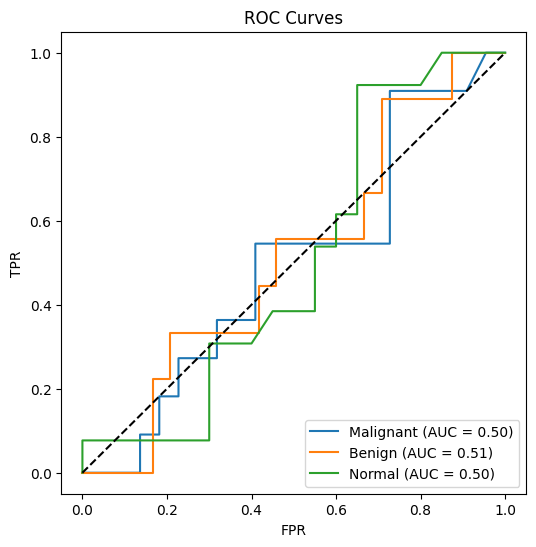

Confusion matrix save failed: 'ConfusionMatrixDisplay' object has no attribute 'figure'
Saved metrics and plots to results/20250814_150536


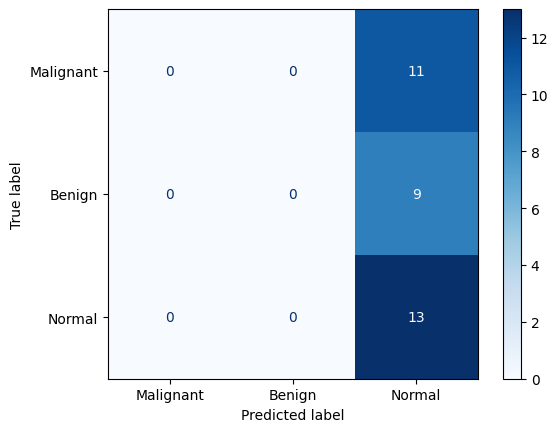

In [52]:

# Run when executed as script in notebook cell
if __name__ == '__main__':
    # Uncomment to run training directly
    #train_and_evaluate(CONFIG)
    train_with_improvements(CONFIG, augment=True, upsample=True)

In [53]:
# Diagnostic cell: inspect shapes and run feature extraction to find cardinality issues
print('Starting diagnostic...')
(X_img_train, X_img_val, X_img_test,
 X_meta_train, X_meta_val, X_meta_test,
 X_txt_train, X_txt_val, X_txt_test,
 y_train, y_val, y_test,
 label_names, class_weight_dict) = prepare_dataset(CONFIG)

print('\nDataset shapes:')
print('X_img_train, X_img_val, X_img_test ->', X_img_train.shape, X_img_val.shape, X_img_test.shape)
print('X_meta_train, X_meta_val, X_meta_test ->', X_meta_train.shape, X_meta_val.shape, X_meta_test.shape)
print('X_txt_train, X_txt_val, X_txt_test ->', X_txt_train.shape, X_txt_val.shape, X_txt_test.shape)
print('y_train, y_val, y_test ->', y_train.shape, y_val.shape, y_test.shape)

from collections import Counter
print('\nLabel distribution (train):', Counter(np.argmax(y_train, axis=1)))
print('Label distribution (val):', Counter(np.argmax(y_val, axis=1)))
print('Label distribution (test):', Counter(np.argmax(y_test, axis=1)))

# Check saved feature files (if any)
feat_paths = [os.path.join(CONFIG['save_features_dir'], n) for n in CONFIG['features_names']]
for p in feat_paths:
    print(p, 'exists=', os.path.exists(p))
    if os.path.exists(p):
        try:
            arr = np.load(p)
            print(' -> shape', arr.shape)
        except Exception as e:
            print(' -> failed to load:', e)

print('\nNow extracting (or loading) image features for the current arrays (this may be slow)...')
X_train_feats, X_val_feats, X_test_feats = extract_image_features(X_img_train, X_img_val, X_img_test, CONFIG)
print('Extracted feature shapes:', X_train_feats.shape, X_val_feats.shape, X_test_feats.shape)

print('\nPost-extraction alignment check:')
print('len X_train_feats', X_train_feats.shape[0], 'len X_meta_train', X_meta_train.shape[0], 'len X_txt_train', X_txt_train.shape[0], 'len y_train', y_train.shape[0])
print('len X_val_feats', X_val_feats.shape[0], 'len X_meta_val', X_meta_val.shape[0], 'len X_txt_val', X_txt_val.shape[0], 'len y_val', y_val.shape[0])
print('len X_test_feats', X_test_feats.shape[0], 'len X_meta_test', X_meta_test.shape[0], 'len X_txt_test', X_txt_test.shape[0], 'len y_test', y_test.shape[0])

# If mismatch, print indices where sizes differ
train_lengths = [X_train_feats.shape[0], X_meta_train.shape[0], X_txt_train.shape[0], y_train.shape[0]]
if len(set(train_lengths)) != 1:
    print('\nTRAIN mismatch lengths:', train_lengths)

val_lengths = [X_val_feats.shape[0], X_meta_val.shape[0], X_txt_val.shape[0], y_val.shape[0]]
if len(set(val_lengths)) != 1:
    print('\nVAL mismatch lengths:', val_lengths)

test_lengths = [X_test_feats.shape[0], X_meta_test.shape[0], X_txt_test.shape[0], y_test.shape[0]]
if len(set(test_lengths)) != 1:
    print('\nTEST mismatch lengths:', test_lengths)

print('\nDiagnostic complete. If mismatches remain, we should enforce a canonical patient ID ordering when building arrays.')

Starting diagnostic...
Preparing dataset...
Loaded metadata with 2006 entries.
Loaded 2006 text entries.
Loading images for 1605 patients...
Loading images for patient 69...
Loading images for patient 184...
Loading images for patient 162...
Loading images for patient 184...
Loading images for patient 162...
Loading images for patient 304...
Loading images for patient 304...
Loading images for patient 170...
Loading images for patient 191...
Loading images for patient 170...
Loading images for patient 191...
Loading images for patient 81...
Loading images for patient 81...
Loading images for patient 16...
Loading images for patient 16...
Loading images for patient 196...
Loading images for patient 196...
Loading images for patient 185...
Loading images for patient 185...
Loading images for patient 232...
Loading images for patient 232...
Loading images for patient 30...
Loading images for patient 30...
Loading images for patient 202...
Loading images for patient 202...
Loading images f

/tmp/ipykernel_132351/648856965.py:51: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels_encoded, label_names = pd.factorize(labels_filtered)


Train size: 231, Val size: 58, Test size: 33

Dataset shapes:
X_img_train, X_img_val, X_img_test -> (231, 8, 224, 224, 1) (58, 8, 224, 224, 1) (33, 8, 224, 224, 1)
X_meta_train, X_meta_val, X_meta_test -> (231, 586) (58, 586) (33, 586)
X_txt_train, X_txt_val, X_txt_test -> (231, 592) (58, 592) (33, 592)
y_train, y_val, y_test -> (231, 3) (58, 3) (33, 3)

Label distribution (train): Counter({2: 79, 0: 76, 1: 76})
Label distribution (val): Counter({2: 24, 1: 17, 0: 17})
Label distribution (test): Counter({2: 13, 0: 11, 1: 9})
model/X_img_train_feats.npy exists= True
 -> shape (237, 64)
model/X_img_val_feats.npy exists= True
 -> shape (58, 64)
model/X_img_test_feats.npy exists= True
 -> shape (33, 64)

Now extracting (or loading) image features for the current arrays (this may be slow)...
Saved features shape mismatch. saved= [237, 58, 33] expected= [231, 58, 33] 
Recomputing features...
Loaded RadImageNet weights.
Loaded RadImageNet weights.
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step
15/15 